In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numba import njit

In [2]:

def nonlinearDiffAOS(mat, lamb, n_iteration, step=.25, h_grid=1):
    l_vec = len(mat.flatten())
    height, width = mat.shape[:2]
    state = mat.copy()
    # diff_hor, diff_ver = GR(state, 2)
    # g_current_iter_ver = diffusivity(diff_ver, lamb)
    # g_current_iter_hor = diffusivity(diff_hor, lamb)
    for _ in range(n_iteration):
        diff_hor, diff_ver = GR(state, 2)
        g_current_iter_ver = diffusivity(diff_ver, lamb)
        g_current_iter_hor = diffusivity(diff_hor, lamb)

        q_upper_ver, q_diagonal_ver, q_lower_ver = build_matrix_q_2d(g_current_iter_ver.T, step=step, h_grid=h_grid)
        q_upper_hor, q_diagonal_hor, q_lower_hor = build_matrix_q_2d(g_current_iter_hor, step=step, h_grid=h_grid)

        state_ver = thomas(q_lower_ver, q_diagonal_ver, q_upper_ver, state.copy().T.flatten()).reshape(width, height).T
        state_hor = thomas(q_lower_hor, q_diagonal_hor, q_upper_hor, state.copy().flatten()).reshape(height, width)

        state = state_ver + state_hor
#         plt.figure()
#         plt.imshow(state_ver, cmap='gray')
#         plt.show()
#         plt.figure()
#         plt.imshow(state_hor, cmap='gray')
#         plt.show()
#         time.sleep(2)
    return state

In [3]:
def diffusivity(mat,lamb):
    eps=10e-5
    ret_val=1-np.exp(-3.315/(mat/lamb)**4)
    ret_val[mat<=0]=1
    return ret_val


In [4]:

def build_matrix_q_2d(mat, step, h_grid=1):
    vec_mat = mat.flatten()
    next_pixel = np.roll(vec_mat, 1)
    previous_pixel = np.roll(vec_mat, -1)
    l_upper = -4 * step * (vec_mat + previous_pixel) / (2 * h_grid ** 2)
    l_diagonal = 2 + 4 * step * (2 * vec_mat + next_pixel + previous_pixel) / (2 * h_grid ** 2)
    l_lower = -4 * step * (vec_mat + next_pixel) / (2 * h_grid ** 2)

    return np.array(l_upper[:-1]), np.array(l_diagonal), np.array(l_lower[1:])

In [5]:
def GR(img, sigma):
    k_width = int(np.round(2 * sigma))
    gaussian_window = np.zeros((2 * k_width + 1, 2 * k_width + 1))
    for m in range(2 * k_width + 1):
        for n in range(2 * k_width + 1):
            power = -(abs(m - k_width) + abs(n - k_width)) / sigma
            gaussian_window[m, n] = np.exp(power)
    gaussian_window = gaussian_window / np.sum(gaussian_window / 2)
    gaussian_window_gx_s1 = gaussian_window.copy()
    gaussian_window_gx_s2 = gaussian_window.copy()
    gaussian_window_gy_s1 = gaussian_window.copy()
    gaussian_window_gy_s2 = gaussian_window.copy()

    gaussian_window_gx_s1[:, k_width::] = 0
    gaussian_window_gx_s2[:, :k_width + 1] = 0
    gaussian_window_gy_s1[k_width::, :] = 0
    gaussian_window_gy_s2[:k_width + 1, :] = 0

    gx_s1 = cv2.filter2D(img, -1, gaussian_window_gx_s1, borderType=cv2.BORDER_REFLECT)
    gx_s2 = cv2.filter2D(img, -1, gaussian_window_gx_s2, borderType=cv2.BORDER_REFLECT)
    gy_s1 = cv2.filter2D(img, -1, gaussian_window_gy_s1, borderType=cv2.BORDER_REFLECT)
    gy_s2 = cv2.filter2D(img, -1, gaussian_window_gy_s2, borderType=cv2.BORDER_REFLECT)

    gx = np.log(gx_s1 / gx_s2)
    gy = np.log(gy_s1 / gy_s2)
    gx[np.isfinite(gx) == False] = 0
    gy[np.isfinite(gy) == False] = 0
    return gx, gy


In [6]:
def thomas(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]
    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

In [7]:
img=cv2.imread('lena.tif',0).astype('float64')

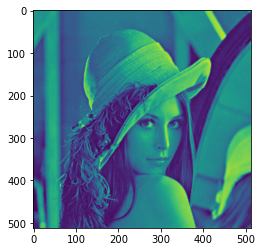

In [8]:
plt.imshow(img)

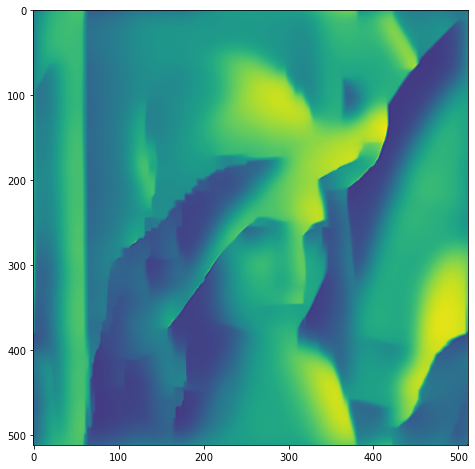

In [10]:
aa=nonlinearDiffAOS(img,.05,10,step=10)
plt.figure(figsize=(12,8))
plt.imshow(aa)